# GNEMS scratchpad

## Imports and Constants

In [1]:
import torch
import numpy as np
import time
from PIL import Image
import skimage.segmentation
import skimage.color
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import evaluate
import pandas as pd
import json
import maxflow
import plotly.express as px
import pickle

# Find fastest device available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Select backend for JIT compilation based on device (inductor is best but MPS only supports aot_eager)
jit_backend = "aot_eager" if device == "mps" else "inductor"

print("Using device:", device)
print("Using JIT backend:", jit_backend)

# Load model from cifar100.pt
weights = torch.load("cifar100.pt")

class SmallCNN(torch.nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(64 * 8 * 8, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
cifar_classifier = SmallCNN()
cifar_classifier.load_state_dict(weights)
cifar_classifier.eval()
cifar_classifier.to(device)

Using device: mps
Using JIT backend: aot_eager


SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=100, bias=True)
  )
)

## Algorithm

In [2]:
# Define CNN module for GNEMS to use
class GNEMNet(torch.nn.Module):
    def __init__(self, image_size=(32,32), k=10, n_filters=16, dropout=0.2):
        super(GNEMNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, n_filters, 3, padding=1)
        self.BN1 = torch.nn.BatchNorm2d(n_filters)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(n_filters, 1, 3, padding=1)
        self.BN2 = torch.nn.BatchNorm2d(1)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.output = torch.nn.Linear(image_size[0] * image_size[1], k)

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        x = torch.softmax(x, dim=1)
        return x
    
def find_nearest_compatible_size(numbers, target=14):
    remainders = numbers % target
    shape = numbers + (target - remainders)
    return shape

class GNEMNet_pretrained(torch.nn.Module):
    def __init__(self, image_size=(32,32), k=10, n_filters=16, dropout=0.2):
        super(GNEMNet_pretrained, self).__init__()
        self.embedding = cifar_classifier
        # get output size of embedding
        self.embedding.eval()
        with torch.no_grad():
            self.embedding_output_size = self.embedding(torch.zeros(1, 3, 32, 32).to(device)).shape[1]
        self.cluster = torch.nn.Linear(100, k)

    def forward(self, x):
        # upsample to self.embedding_input_size
        x = torch.nn.functional.interpolate(x, (32,32), mode="nearest")
        # normalize to mean 0.5 and std 0.5
        x = (x / 255)
        print(x.mean(), x.std())
        x = self.embedding(x)
        x = self.cluster(x)
        x = torch.softmax(x, dim=1)
        return x

class TileDS(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]
    
def tile(image, d):
    assert image.shape[0] % d == 0 or image.shape[1] % d == 0 # Image dimensions must be divisible by d
    tile_width = (image.shape[0] // d)
    tile_height = (image.shape[1] // d)
    image_tensor = torch.tensor(image, dtype=torch.float32)
    if len(image_tensor.shape) < 3:
        image_tensor = image_tensor.unsqueeze(2)
    tiles = image_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
    tiles = tiles.permute(0, 1, 3, 4, 2)
    tiles = tiles.reshape(tiles.shape[0] * tiles.shape[1], tile_width, tile_height, tiles.shape[4])
    return tiles

def initial_labels(image, d, n_segments, method="slic"):
    if method == "slic":
        seg = skimage.segmentation.slic(image, compactness=1, max_num_iter=10,
                                        n_segments=n_segments, start_label=0,
                                        enforce_connectivity=False, convert2lab=True)
        
        # while len(np.unique(seg)) > n_segments, merge smallest segments
        while len(np.unique(seg)) > n_segments:
            # count number of pixels in each segment
            segments, counts = np.unique(seg, return_counts=True)
            # find smallest segment
            smallest1 = segments[np.argmin(counts)]
            # find second smallest segment
            counts[smallest1] = np.max(counts)
            smallest2 = segments[np.argmin(counts)]
            # merge smallest segments
            seg[seg == smallest1] = smallest2

        t = torch.tensor(seg).unsqueeze(0).unsqueeze(0).float()
        labels = torch.nn.functional.interpolate(t, (d, d), mode="nearest")
        labels = labels.squeeze().to(torch.int64).reshape(d * d)
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels
    elif method == "random":
        labels = torch.randint(n_segments, (d * d,))
        labels = torch.nn.functional.one_hot(labels, n_segments).float()
        return labels

def graph_cut(probabilities, d, k, lambda_):
    lambda_ = lambda_
    # avoid division by zero
    probabilities[probabilities == 0] = 1e-10
    unary = -1 * np.log(probabilities.reshape(d, d, k))
    pairwise = (1 - np.eye(k)) * lambda_
    # result = gco.cut_grid_graph_simple(unary, pairwise)
    result = maxflow.aexpansion_grid(unary.astype(np.double), pairwise.astype(np.double))
    result = result.reshape(d * d)
    return result

def edge_align(pixelwise_predictions_, slic_segmentation_):
    start = time.time()
    pixelwise_predictions = pixelwise_predictions_.to(device) # (512, 512, 10)
    slic_segmentation = slic_segmentation_.to(device)
    slic_segment_indices = torch.unique(slic_segmentation).to(device)

    segmentation_shape = slic_segmentation.shape
    slic_segmentation = torch.flatten(slic_segmentation)
    segment_maps = (slic_segmentation.unsqueeze(0) == slic_segment_indices.unsqueeze(1)).reshape(len(slic_segment_indices), segmentation_shape[0], segmentation_shape[1]) # (916, 512, 512)

    batch_size = 128  # Adjust the batch size as needed
    num_batches = segment_maps.shape[0] // batch_size
    if segment_maps.shape[0] % batch_size != 0:
        num_batches += 1

    averages = []
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, segment_maps.shape[0])
        
        # Perform element-wise multiplication for the current batch
        batch_product = pixelwise_predictions.unsqueeze(0) * segment_maps[start_idx:end_idx].unsqueeze(-1)
        
        # Reshape the batch product to (512^2, 10)
        reshaped_product = batch_product.reshape(batch_product.shape[0], -1, pixelwise_predictions.shape[-1])
        
        # Calculate the average of non-zero elements along axis 0
        nonzero_count = reshaped_product.sum(dim=-1).count_nonzero(dim=1)
        nonzero_average = reshaped_product.sum(dim=1) / nonzero_count.unsqueeze(-1)

        # Append the average to the list
        averages.append(nonzero_average)

    averages = torch.cat(averages, dim=0)
    segment_predictions = averages.argmax(dim=1) # (916)

    # Create a broadcasted mask using broadcasting
    mask = slic_segmentation.unsqueeze(-1) == slic_segment_indices.unsqueeze(0)

    # Perform element-wise multiplication and sum along the second dimension
    integer_predictions = (mask.float() * segment_predictions.unsqueeze(0)).sum(dim=1)

    integer_predictions = integer_predictions.reshape(segmentation_shape)
    
    return integer_predictions


class GNEMS_Segmentor:
    def __init__(self, d=16, n_filters=16, dropout=0.2,
                lambda_=0.3, size=(512, 512), lr=0.001,
                iterations=100, subset_size=0.5,
                prediction_stride=1, slic_segments=100,
                sigma=3, compactness=10, seed=0, k=10, epochs=10,
                initialization_method="slic", epoch_schedule=None,
                max_epochs=40, min_epochs=10):
        self.d = d
        self.n_filters = n_filters
        self.dropout = dropout
        self.lambda_ = lambda_
        self.size = size
        self.tile_size = (size[0] // d, size[1] // d)
        self.lr = lr
        self.iterations = iterations
        self.subset_size = subset_size
        self.prediction_stride = prediction_stride
        self.seed = seed
        self.net = None
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.slic_segments = slic_segments
        self.sigma = sigma
        self.compactness = compactness
        self.k = k
        self.initial_labels = None
        self.epochs = epochs
        self.initialization_method = initialization_method
        self.epoch_schedule = epoch_schedule
        self.max_epochs = max_epochs
        self.min_epochs = min_epochs

    def fit(self, image):
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.image = image

        assert image.shape[0] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[1] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[2] == 3 # image must channel last

        # Generate tiles and initial labels
        X = tile(image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        y_initial = initial_labels(image, self.d, self.k, method=self.initialization_method).to(device)
        self.initial_labels = y_initial

        # Initialize CNN
        self.net = GNEMNet(image_size=self.tile_size, n_filters=self.n_filters, dropout=self.dropout, k=self.k).to(device)
        
        # Initialize optimizer and loss function
        y_intermediate = y_initial.clone().detach().argmax(dim=1).type(torch.float32)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)

        # Train CNN
        itertimes = []
        graphtimes = []
        for iteration in range(self.iterations):
            start = time.time()
            shuffled_idx = torch.randperm(X.shape[0])
            X_shuffled = X[shuffled_idx]
            y_intermediate_shuffled = y_intermediate[shuffled_idx]
            X_subset = X_shuffled[:int(self.subset_size * X.shape[0])]
            y_intermediate_subset = y_intermediate_shuffled[:int(self.subset_size * X.shape[0])]
            n_epochs = self.epochs
            if self.epoch_schedule is not None:
                n_epochs = self.epoch_schedule(iteration, max_epochs=self.max_epochs, min_epochs=self.min_epochs, n_iter=self.iterations)
            for epoch in range(n_epochs):
                # Perform network step
                inputs = X_subset
                labels = y_intermediate_subset.type(torch.long)
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                self.losses.append(loss.item() / X.shape[0])
                loss.backward()
                optimizer.step()

            # DEBUG WITHOUT GRAPH
            # Set pseudo-labels to network output rounded to nearest integer
            outputs = self.net(X)
            # y_intermediate = outputs.argmax(dim=1).to(device)

            # Calculate probabilities for each tile
            probabilities = outputs.detach().squeeze(1).cpu().numpy()
            self.intermediate_probabilities.append(probabilities)

            # Skip graph step on last iteration
            if iteration != self.iterations - 1:
                # Perform graph step
                graph_start = time.time()
                partition = torch.tensor(graph_cut(probabilities, self.d, self.k, self.lambda_), dtype=torch.int64)
                partition = torch.nn.functional.one_hot(partition, self.k)
                self.intermediate_partitions.append(partition)
                graphtimes.append(time.time() - graph_start)

                # Update pseudo-labels
                y_intermediate = torch.Tensor(partition).to(device).argmax(dim=1).type(torch.long)

            itertimes.append(time.time() - start)
        # print(f"Average iteration time: {np.mean(itertimes)}")

    def predict_low_res(self):
        X = tile(self.image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        seg = self.net(X).detach().squeeze(1).reshape(self.d, self.d, self.k).cpu().numpy()
        return seg

    def predict(self, show_progress=True):
        stride = self.prediction_stride
        image = self.image
        image_tensor = torch.tensor(image, dtype=torch.float32)
        all_tiles = image_tensor.unfold(0, self.tile_size[0], stride).unfold(1, self.tile_size[1], stride).reshape(-1, 3, self.tile_size[0], self.tile_size[1]).to(device)
        all_tiles_ds = TileDS(all_tiles)

        # set up dataloaders
        batch_size = 4096
        if device == "cuda":
            batch_size = 16384
        loader = torch.utils.data.DataLoader(all_tiles_ds, batch_size=batch_size, shuffle=False)
        n_batches = len(loader)

        with torch.no_grad():
            all_tiles_predictions = torch.zeros((len(all_tiles_ds), self.k)).to(device)
            iterator = tqdm(enumerate(loader), total=n_batches) if show_progress else enumerate(loader)
            for batch_i, batch in iterator:
                batch_predictions = self.net(batch)
                all_tiles_predictions[batch_i*loader.batch_size:(batch_i+1)*loader.batch_size] = batch_predictions.squeeze(1)

        predictions = all_tiles_predictions.reshape(((self.size[0] - self.tile_size[0]) // stride) + 1, ((self.size[1] - self.tile_size[1]) // stride) + 1, self.k)
        predictions = predictions.permute(2, 0, 1)

        pixelwise_probabilities = torch.nn.functional.interpolate(predictions.unsqueeze(0).unsqueeze(0), size=[self.k, image.shape[0], image.shape[1]], mode='trilinear')
        pixelwise_probabilities = pixelwise_probabilities.squeeze(0).squeeze(0).permute(1, 2, 0)
        segments = skimage.segmentation.slic(image, n_segments=self.slic_segments, sigma=self.sigma, compactness=self.compactness)
        segments = torch.tensor(segments).to(device)
        segmentation = edge_align(pixelwise_probabilities, segments)
        segmentation = segmentation.type(torch.uint8)
        return segmentation

## Testbench

/Users/isaac/miniforge3/envs/pytorch/lib/python3.10/site-packages/torch/nn/functional.py:3962: UserWarning: The operator 'aten::upsample_trilinear3d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.upsample_trilinear3d(input, output_size, align_corners, scale_factors)


Total training time: 2.9440629482269287
Total prediction time: 1.1985700130462646
Total time taken: 4.142672777175903


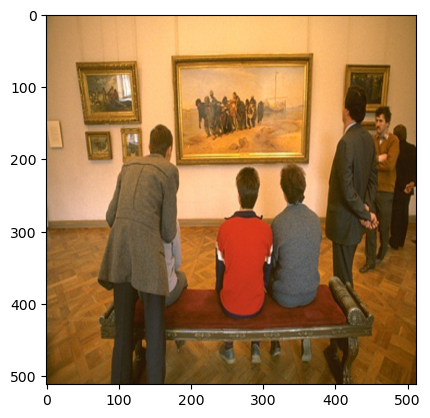

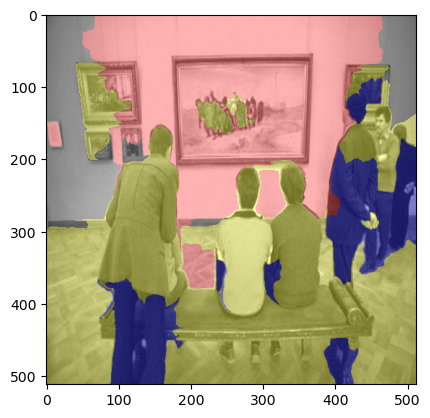

In [3]:
def epoch_schedule(x_, max_epochs=40, min_epochs=10, n_iter=4):
    return_int = False
    if not isinstance(x_, np.ndarray):
        x = np.array([x_])
        return_int = True
    else:
        x = x_
    x[x == 0] = 1
    v = ((5*n_iter)/x) + min_epochs
    too_high = v > max_epochs
    v[too_high] = max_epochs
    # convert to int
    v = v.astype(int)
    if return_int:
        return v[0]
    else:
        return v

image = np.array(Image.open("tmp_images/128035.jpg").resize((512, 512)))[:,:,:3]
k = 25
d = 32
lambda_ = 4

start_time = time.time()
train_start = time.time()
segmentor = GNEMS_Segmentor(iterations=8, k=k, d=d, lambda_=lambda_,
                            subset_size=0.5, lr=0.005, epochs=40, n_filters=16,
                            slic_segments=500, prediction_stride=8,
                            initialization_method="slic", compactness=10, sigma=2,
                            epoch_schedule=epoch_schedule, max_epochs=40, min_epochs=10)
segmentor.fit(image)
train_end = time.time()

prediction_start = time.time()
seg = segmentor.predict(show_progress=False)
prediction_end = time.time()
end_time = time.time()

print(f"Total training time: {train_end - train_start}")
print(f"Total prediction time: {prediction_end - prediction_start}")
print(f"Total time taken: {end_time - start_time}")

plt.imshow(image)
plt.show()
plt.imshow(skimage.color.label2rgb(seg.to("cpu").numpy(), image))
plt.show()

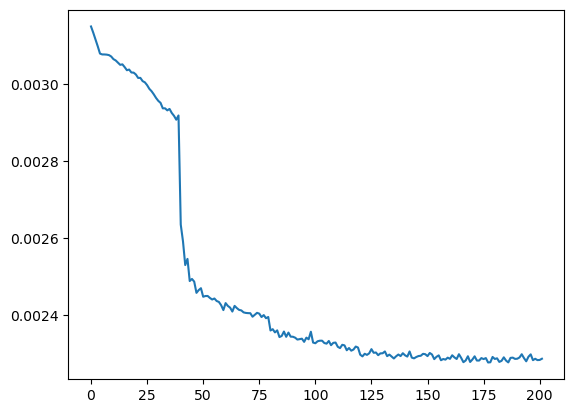

In [4]:
plt.plot(segmentor.losses)
plt.show()

In [23]:
# load csv as array
csv = np.loadtxt("tmp_images/128035-4.csv", delimiter=",")
resized = torch.nn.functional.interpolate(seg.unsqueeze(0).unsqueeze(0), (321, 481), mode="nearest").squeeze(0).squeeze(0).type(torch.uint8).cpu().numpy()
evaluate.smart_jaccard(resized, csv)

0.5562382936477661

## Experiments

### Noise Tolerance

Running noise level 0.0...


100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


Running noise level 0.1...


100%|██████████| 10/10 [00:49<00:00,  5.00s/it]


Running noise level 0.2...


100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


Running noise level 0.3...


100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Running noise level 0.4...


100%|██████████| 10/10 [00:50<00:00,  5.00s/it]


Running noise level 0.5...


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


Running noise level 0.6...


100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


Running noise level 0.7...


100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


Running noise level 0.8...


100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


Running noise level 0.9...


 10%|█         | 1/10 [00:04<00:41,  4.59s/it]/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/2382668821.py:77: RuntimeWarning: divide by zero encountered in log
  unary = -1 * np.log(probabilities.reshape(d, d, k))
100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Running noise level 1.0...


100%|██████████| 10/10 [00:43<00:00,  4.32s/it]
/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/1450673051.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("Noise_Level").mean()


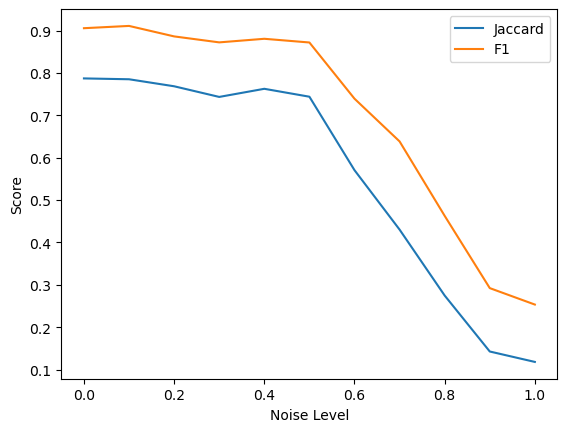

In [24]:
noise_levels = [f'{level:.1f}' for level in np.arange(0, 1.1, 0.1)]
for noise_level in noise_levels:
    print(f"Running noise level {noise_level}...")
    os.makedirs(f"noise_experiment_results/{noise_level}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/{noise_level}/{i:04d}.png").resize((512, 512)))[:,:,:3]
        segmentor = GNEMS_Segmentor(iterations=4, k=10, d=32, lambda_=12, subset_size=0.5, lr=0.005, epochs=40, n_filters=32, slic_segments=1000, prediction_stride=16, initialization_method="slic")
        segmentor.fit(image)
        seg = segmentor.predict(show_progress=False)
        plt.imsave(f"noise_experiment_results/{noise_level}/{i:04d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for noise_level in np.arange(0, 1.1, 0.1):
        noise_level_string = f"{noise_level:.1f}"
        segmentation_image = np.array(Image.open(f"noise_experiment_results/{noise_level_string}/{gt_string}.png"))[:,:,:3]
        colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
        segmentation_map = np.zeros((512, 512))
        for i, color in enumerate(colors):
            segmentation_map[(segmentation_image == color).all(axis=2)] = i
        jaccard = evaluate.smart_jaccard(gt, segmentation_map)
        f1 = evaluate.smart_f1_score(gt, segmentation_map)
        results.append({"Image_ID": gt_string, "Noise_Level": noise_level, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("Noise_Level").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Noise Level")
plt.ylabel("Score")
plt.legend()
plt.show()

### Patch Size Tuning

Running noise level 16...


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/2382668821.py:77: RuntimeWarning: divide by zero encountered in log
  unary = -1 * np.log(probabilities.reshape(d, d, k))
100%|██████████| 10/10 [02:43<00:00, 16.34s/it]


Running noise level 32...


100%|██████████| 10/10 [02:29<00:00, 14.90s/it]


Running noise level 64...


100%|██████████| 10/10 [02:33<00:00, 15.31s/it]
/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/459546102.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("Patch_Size").mean()


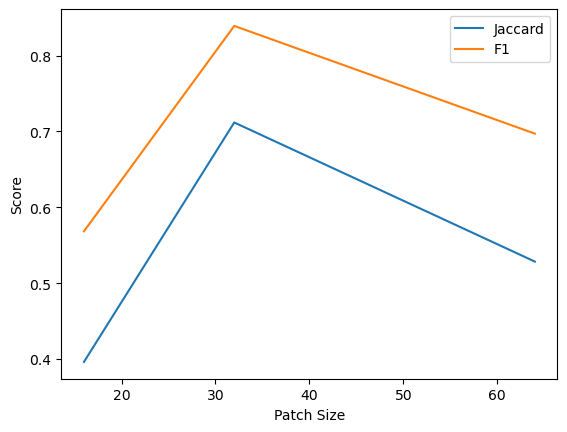

In [25]:
patch_sizes = [16,32,64]
for d in patch_sizes:
    print(f"Running patch size {d}...")
    os.makedirs(f"patch_size_experiment_results/{d}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/0.4/{i:04d}.png").resize((512, 512)))[:,:,:3]
        for trial_num in range(3):
            segmentor = GNEMS_Segmentor(iterations=4, k=10, d=d, lambda_=12, subset_size=0.5, lr=0.005, epochs=40, n_filters=32, slic_segments=1000, prediction_stride=16, initialization_method="slic")
            segmentor.fit(image)
            seg = segmentor.predict(show_progress=False)
            plt.imsave(f"patch_size_experiment_results/{d}/{i:04d}_{trial_num:02d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for d in patch_sizes:
        for trial_num in range(3):
            segmentation_image = np.array(Image.open(f"patch_size_experiment_results/{d}/{gt_string}_{trial_num:02d}.png"))[:,:,:3]
            colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
            segmentation_map = np.zeros((512, 512))
            for i, color in enumerate(colors):
                segmentation_map[(segmentation_image == color).all(axis=2)] = i
            jaccard = evaluate.smart_jaccard(gt, segmentation_map)
            f1 = evaluate.smart_f1_score(gt, segmentation_map)
            results.append({"Image_ID": gt_string, "Patch_Size": d, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("Patch_Size").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Patch Size")
plt.ylabel("Score")
plt.legend()
plt.show()

### Number of Epochs

Running number of epochs = 20...


 20%|██        | 2/10 [00:27<01:49, 13.65s/it]/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/2382668821.py:77: RuntimeWarning: divide by zero encountered in log
  unary = -1 * np.log(probabilities.reshape(d, d, k))
100%|██████████| 10/10 [02:14<00:00, 13.45s/it]


Running number of epochs = 30...


100%|██████████| 10/10 [02:06<00:00, 12.62s/it]


Running number of epochs = 40...


100%|██████████| 10/10 [02:22<00:00, 14.25s/it]


Running number of epochs = 50...


100%|██████████| 10/10 [02:31<00:00, 15.17s/it]


Running number of epochs = 60...


100%|██████████| 10/10 [03:24<00:00, 20.45s/it]
/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/731096263.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("n_epochs").mean()


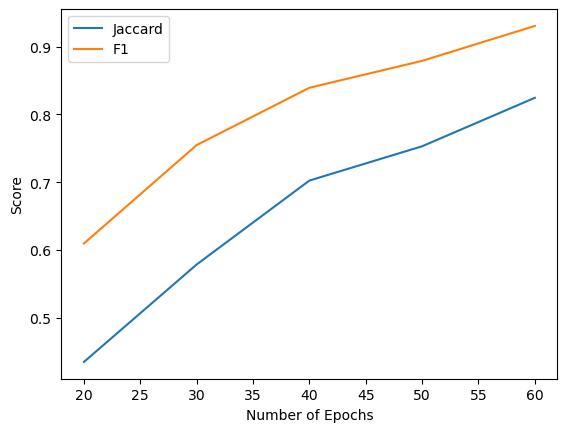

In [27]:
n_epoch_options = [20,30,40,50,60]
for n_epochs in n_epoch_options:
    print(f"Running number of epochs = {n_epochs}...")
    os.makedirs(f"epoch_experiment_results/{n_epochs}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/0.4/{i:04d}.png").resize((512, 512)))[:,:,:3]
        for trial_num in range(3):
            segmentor = GNEMS_Segmentor(iterations=4, k=10, d=32, lambda_=12, subset_size=0.5, lr=0.005, epochs=n_epochs, n_filters=32, slic_segments=1000, prediction_stride=16, initialization_method="slic")
            segmentor.fit(image)
            seg = segmentor.predict(show_progress=False)
            plt.imsave(f"epoch_experiment_results/{n_epochs}/{i:04d}_{trial_num:02d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for n_epochs in n_epoch_options:
        for trial_num in range(3):
            segmentation_image = np.array(Image.open(f"epoch_experiment_results/{n_epochs}/{gt_string}_{trial_num:02d}.png"))[:,:,:3]
            colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
            segmentation_map = np.zeros((512, 512))
            for i, color in enumerate(colors):
                segmentation_map[(segmentation_image == color).all(axis=2)] = i
            jaccard = evaluate.smart_jaccard(gt, segmentation_map)
            f1 = evaluate.smart_f1_score(gt, segmentation_map)
            results.append({"Image_ID": gt_string, "n_epochs": n_epochs, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("n_epochs").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()

### Number of Filters

Running number of filters = 8...


 70%|███████   | 7/10 [01:51<00:48, 16.20s/it]/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/2382668821.py:77: RuntimeWarning: divide by zero encountered in log
  unary = -1 * np.log(probabilities.reshape(d, d, k))
100%|██████████| 10/10 [02:40<00:00, 16.06s/it]


Running number of filters = 16...


100%|██████████| 10/10 [03:03<00:00, 18.37s/it]


Running number of filters = 32...


100%|██████████| 10/10 [07:39<00:00, 45.90s/it]


Running number of filters = 64...


100%|██████████| 10/10 [02:42<00:00, 16.25s/it]
/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/412869543.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("n_filters").mean()


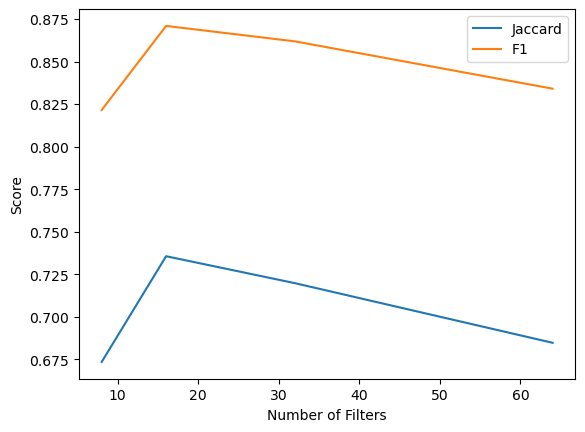

In [28]:
n_filter_options = [8,16,32,64]
for n_filters in n_filter_options:
    print(f"Running number of filters = {n_filters}...")
    os.makedirs(f"filter_experiment_results/{n_filters}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/0.4/{i:04d}.png").resize((512, 512)))[:,:,:3]
        for trial_num in range(3):
            segmentor = GNEMS_Segmentor(iterations=4, k=10, d=32, lambda_=12, subset_size=0.5, lr=0.005, epochs=40, n_filters=n_filters, slic_segments=1000, prediction_stride=16, initialization_method="slic")
            segmentor.fit(image)
            seg = segmentor.predict(show_progress=False)
            plt.imsave(f"filter_experiment_results/{n_filters}/{i:04d}_{trial_num:02d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for n_filters in n_filter_options:
        for trial_num in range(3):
            segmentation_image = np.array(Image.open(f"filter_experiment_results/{n_filters}/{gt_string}_{trial_num:02d}.png"))[:,:,:3]
            colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
            segmentation_map = np.zeros((512, 512))
            for i, color in enumerate(colors):
                segmentation_map[(segmentation_image == color).all(axis=2)] = i
            jaccard = evaluate.smart_jaccard(gt, segmentation_map)
            f1 = evaluate.smart_f1_score(gt, segmentation_map)
            results.append({"Image_ID": gt_string, "n_filters": n_filters, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("n_filters").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Number of Filters")
plt.ylabel("Score")
plt.legend()
plt.show()

### Lambda

Running lambda = 8...


100%|██████████| 10/10 [02:29<00:00, 14.99s/it]


Running lambda = 10...


 40%|████      | 4/10 [00:57<01:25, 14.21s/it]/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/2382668821.py:77: RuntimeWarning: divide by zero encountered in log
  unary = -1 * np.log(probabilities.reshape(d, d, k))
100%|██████████| 10/10 [02:23<00:00, 14.37s/it]


Running lambda = 12...


100%|██████████| 10/10 [02:25<00:00, 14.59s/it]


Running lambda = 14...


100%|██████████| 10/10 [02:25<00:00, 14.53s/it]


Running lambda = 16...


100%|██████████| 10/10 [02:22<00:00, 14.29s/it]
/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_6265/2088947702.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores_by_noise_level = results_df.groupby("lambda_").mean()


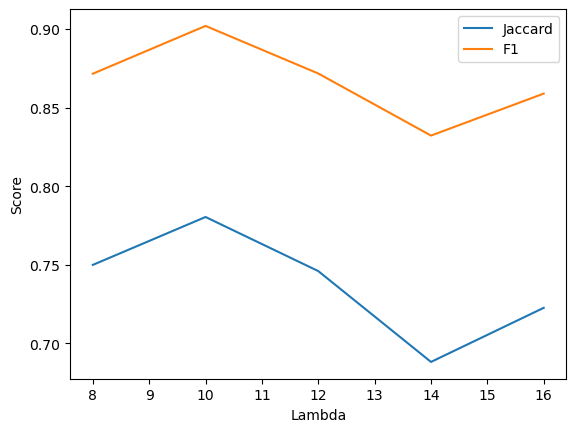

In [29]:
lambda_options = [8,10,12,14,16]
for lambda_ in lambda_options:
    print(f"Running lambda = {lambda_}...")
    os.makedirs(f"lambda_experiment_results/{lambda_:02d}", exist_ok=True)
    for i in tqdm(range(10)):
        image = np.array(Image.open(f"synthetic_color_images/0.4/{i:04d}.png").resize((512, 512)))[:,:,:3]
        for trial_num in range(3):
            segmentor = GNEMS_Segmentor(iterations=4, k=10, d=32, lambda_=lambda_, subset_size=0.5, lr=0.005, epochs=40, n_filters=32, slic_segments=1000, prediction_stride=16, initialization_method="slic")
            segmentor.fit(image)
            seg = segmentor.predict(show_progress=False)
            plt.imsave(f"lambda_experiment_results/{lambda_:02d}/{i:04d}_{trial_num:02d}.png", seg)

results = []
for gt_num in range(10):
    gt_string = f"{gt_num:04d}"
    zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
    colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
    gt = np.zeros((512, 512))
    for i, color in enumerate(colors):
        gt[(zero_noise == color).all(axis=2)] = i
    for lambda_ in lambda_options:
        for trial_num in range(3):
            segmentation_image = np.array(Image.open(f"lambda_experiment_results/{lambda_:02d}/{gt_string}_{trial_num:02d}.png"))[:,:,:3]
            colors = np.unique(segmentation_image.reshape(512**2,3), axis=0)
            segmentation_map = np.zeros((512, 512))
            for i, color in enumerate(colors):
                segmentation_map[(segmentation_image == color).all(axis=2)] = i
            jaccard = evaluate.smart_jaccard(gt, segmentation_map)
            f1 = evaluate.smart_f1_score(gt, segmentation_map)
            results.append({"Image_ID": gt_string, "lambda_": lambda_, "Jaccard": jaccard, "F1": f1})

results_df = pd.DataFrame(results)
scores_by_noise_level = results_df.groupby("lambda_").mean()
plt.plot(scores_by_noise_level.index, scores_by_noise_level["Jaccard"], label="Jaccard")
plt.plot(scores_by_noise_level.index, scores_by_noise_level["F1"], label="F1")
plt.xlabel("Lambda")
plt.ylabel("Score")
plt.legend()
plt.show()

### Time vs. performance

#### Arbitrary

In [59]:
def epoch_schedule(x_, max_epochs=40, min_epochs=10, n_iter=4):
    return_int = False
    if not isinstance(x_, np.ndarray):
        x = np.array([x_])
        return_int = True
    else:
        x = x_
    v = ((5*n_iter)/x) + min_epochs
    too_high = v > max_epochs
    v[too_high] = max_epochs
    # convert to int
    v = v.astype(int)
    if return_int:
        return v[0]
    else:
        return v

gt_string = "0001"
noise_level = 0.5
image = np.array(Image.open(f"synthetic_color_images/{noise_level}/{gt_string}.png").resize((512, 512)))[:,:,:3]
k = 10
d = 32
lambda_ = 8
iterations = 4
subset_size = 0.5
lr = 0.01
epochs = 40
n_filters = 32
slic_segments = 100
prediction_stride = 32
initialization_method = "slic"
compactness = 80
sigma = 3
schedule = epoch_schedule
max_epochs = 80
min_epochs = 10


start_time = time.time()
train_start = time.time()
segmentor = GNEMS_Segmentor(iterations=iterations, k=k, d=d, lambda_=lambda_,
                            subset_size=subset_size, lr=lr, epochs=epochs, n_filters=n_filters,
                            slic_segments=slic_segments, prediction_stride=prediction_stride,
                            initialization_method="slic", compactness=compactness, sigma=sigma,
                            epoch_schedule=epoch_schedule, max_epochs=max_epochs, min_epochs=min_epochs)
segmentor.fit(image)
train_end = time.time()

prediction_start = time.time()
seg = segmentor.predict(show_progress=False)
prediction_end = time.time()
end_time = time.time()

training_time = train_end - train_start
prediction_time = prediction_end - prediction_start
total_time = end_time - start_time

zero_noise = np.array(Image.open(f"synthetic_color_images/0.0/{gt_string}.png").resize((512, 512)))[:,:,:3]
colors = np.unique(zero_noise.reshape(512**2,3), axis=0)
gt = np.zeros((512, 512))
for i, color in enumerate(colors):
    gt[(zero_noise == color).all(axis=2)] = i

seg = seg.cpu()
colors = np.unique(seg.reshape(512**2), axis=0)
segmentation_map = np.zeros((512, 512))
for i, color in enumerate(colors):
    segmentation_map[seg == color] = i

jaccard = evaluate.smart_jaccard(gt, segmentation_map)
f1 = evaluate.smart_f1_score(gt, segmentation_map)

print(jaccard, "jaccard")
print(total_time, "seconds")

with open("arbitrary_experimentation.json", "r") as j:
    existing_string = j.read()
    results = json.loads(existing_string)

experiment_object = {"gt": gt_string, "noise_level": noise_level,
                     "k": k, "d": d, "lambda_": lambda_,
                     "iterations": iterations, "subset_size": subset_size,
                     "lr": lr, "epochs": epochs, "n_filters": n_filters,
                     "slic_segments": slic_segments, "prediction_stride": prediction_stride,
                     "initialization_method": initialization_method, "compactness": compactness,
                     "sigma": sigma, "max_epochs": max_epochs, "min_epochs": min_epochs,
                     "jaccard": jaccard, "f1": f1, "training_time": training_time,
                     "prediction_time": prediction_time, "total_time": total_time}
results["results"].append(experiment_object)

with open("arbitrary_experimentation.json", "w") as j:
    json.dump(results, j)

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_77863/2547812475.py:8: RuntimeWarning:

divide by zero encountered in divide

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_77863/4160846689.py:77: RuntimeWarning:

divide by zero encountered in log



0.6324878334999084 jaccard
2.2409040927886963 seconds


In [55]:
# Plot search results
with open("arbitrary_experimentation.json", "r") as j:
    results = json.load(j)
results_df = pd.DataFrame(results["results"])

df = results_df

# Select the columns of interest
columns_of_interest = ['total_time', 'jaccard']

# Calculate the correlations with 'total_time
time_correlations = df.drop(columns_of_interest, axis=1).corrwith(df['total_time'], numeric_only=True).reset_index()
time_correlations.columns = ['Column', 'Correlation with total_time']

# Calculate the correlations with 'jaccard'
jaccard_correlations = df.drop(columns_of_interest, axis=1).corrwith(df['jaccard'], numeric_only=True).reset_index()
jaccard_correlations.columns = ['Column', 'Correlation with jaccard']

# drop columns from df with low correlation with both total_time and jaccard
threshold = 0.03
low_correlation_columns = time_correlations[time_correlations["Correlation with total_time"].abs() < threshold]["Column"].values
low_correlation_columns = np.append(low_correlation_columns, jaccard_correlations[jaccard_correlations["Correlation with jaccard"].abs() < threshold]["Column"].values)
df = df.drop(low_correlation_columns, axis=1)

unique_counts = df.nunique()
unique_counts = unique_counts[unique_counts > 1]
sorted_columns = unique_counts.sort_values(ascending=True).index

sorted_columns = sorted_columns.drop("jaccard")
sorted_columns = sorted_columns.append(pd.Index(["jaccard"]))
sorted_columns = sorted_columns.drop("total_time")
sorted_columns = sorted_columns.append(pd.Index(["total_time"]))

df = df[sorted_columns]

# increase parallel_coordinates line width
fig = px.parallel_coordinates(df, color="jaccard")
fig.update_layout(width=1000)
# add title
fig.update_layout(title_text="Parallel Coordinates Plot of Hyperparameter Values and Performance")
# add space between title and plot
fig.update_layout(title_x=0.5, title_y=1)
fig.show()

## Scratchpad

In [ ]:
# (done) Redo experiments with new graphs (including lambda)
# (done) Check prediction normalization in predict function (why)
# Compare with other methods
# Try experiments with different numbers of segments
# Make time vs. [performance, size, etc.] plots
# (done) Try a few real images from BSDS500
# Think of new acronym without EM

# Send results to Jeova
